# Chargement
## Librairies

In [ ]:
!pip install nonconformist
!pip install sklearn
!pip install numpy==1.18.5
!pip install keras==2.6.0
!pip install tensorflow==2.6.0

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nonconformist.nc import NcFactory
from nonconformist.base import RegressorAdapter
from nonconformist.cp import IcpClassifier, IcpRegressor
from nonconformist.nc import ClassifierNc, MarginErrFunc

# Téléphones
## Données
### Chargement

In [3]:
url = 'https://raw.githubusercontent.com/astridgcn/Conformal-Prediction-demos/main/cellphone.csv'
cellphones = pd.read_csv(url, sep = ",")

In [4]:
cellphones

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.20,424,8,1.350,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.70,312,4,1.200,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.00,233,2,1.300,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.00,233,2,1.300,4.0,1.000,3.15,0.0,1700,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1206,3551,4638,178.0,5.46,538,4,1.875,128.0,6.000,12.00,16.0,4080,8.4
157,1296,3211,8016,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9
158,856,3260,8809,150.0,5.50,401,8,2.200,64.0,4.000,20.00,20.0,3000,6.8
159,1296,3211,8946,170.0,5.50,534,4,1.975,128.0,6.000,20.00,8.0,3400,7.9


In [5]:
cellphones.dtypes

Product_id        int64
Price             int64
Sale              int64
weight          float64
resoloution     float64
ppi               int64
cpu core          int64
cpu freq        float64
internal mem    float64
ram             float64
RearCam         float64
Front_Cam       float64
battery           int64
thickness       float64
dtype: object

### Sélection

<AxesSubplot:>

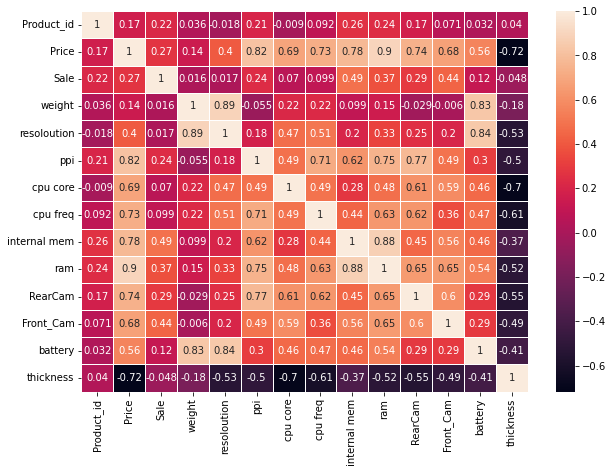

In [6]:
corr = cellphones.corr(method = 'pearson').round(3)
plt.figure(figsize = (10,7))
sns.heatmap(data = corr, annot = True, linewidth = .5) 

## Entraînement
### Préparation
#### Variable d'intérêt

In [7]:
X = pd.DataFrame(np.c_[cellphones['Sale'], cellphones['weight'], cellphones['resoloution'], cellphones['ppi'], cellphones['cpu core'], cellphones['cpu freq'], cellphones['internal mem'], cellphones['ram'], cellphones['RearCam'], cellphones['Front_Cam'], cellphones['battery'], cellphones['thickness']], 
                 columns = ['Scale', 'weight', 'resoloution', 'ppi', 'cpu core', 'cpu freq', 'internal mem', 'ram', 'RearCam', 'Front_Cam', 'battery', 'thickness'])
y = cellphones['Price']

### Division du jeu de données
#### Effectifs

In [8]:
n_train = round(len(cellphones) * 0.6)
n_test = round(len(cellphones) * 0.2)
n_calib = len(cellphones) - (n_train + n_test)
print(n_train, n_test, n_calib)

97 32 32


#### Division

In [9]:
#idx_train, idx_cal, idx_test = idx[:n_train], idx[n_train:(n_train + n_test)], idx[(n_train + n_test):]
X_train = X[0:n_train]
y_train = y[0:n_train]
X_calib = X[n_train:(n_train + n_test)]
y_calib = y[n_train:(n_train + n_test)]
X_test = X[(n_train + n_test):]
y_test = y[(n_train + n_test):]

### Modèle
#### Création du modèle

In [10]:
nc = NcFactory.create_nc(KNeighborsRegressor(n_neighbors=11)) # 0.94 accuracy
#nc = NcFactory.create_nc(RandomForestRegressor(n_estimators=500)) # 0.81 accuracy
#nc = NcFactory.create_nc(DecisionTreeRegressor(min_samples_leaf=5)) # 0.88 accuracy
icp = IcpRegressor(nc)

#### Entraînement

In [11]:
icp.fit(X_train, y_train)

#### Calibration

In [12]:
icp.calibrate(X_calib, y_calib)

## Prédiction
### Prédiction des valeurs
95% de confiance

In [ ]:
y_pred = icp.predict(X_test.values, significance = 0.05)

In [14]:
print("Intervalles de prédiction à 95% de confiance :\n", y_pred[:5, :])
print("\nValeurs réelles :\n", y_test[:5])

Intervalles de prédiction à 95% de confiance :
 [[1766.54545455 4018.18181818]
 [ 858.81818182 3110.45454545]
 [ 858.81818182 3110.45454545]
 [1766.54545455 4018.18181818]
 [ 802.27272727 3053.90909091]]

Valeurs réelles :
 129    2466
130    1357
131    1357
132    2466
133    2266
Name: Price, dtype: int64


#### Niveau de précision

In [15]:
suc = 0
for i in range(n_test):
    if (y_test[(n_train + n_test + i)] > y_pred[i,0]) and (y_test[(n_train + n_test + i)] < y_pred[i,1]):
      suc += 1
acc = suc / n_test
("Précision du modèle :", acc)

('Précision du modèle :', 0.9375)

# Performances des employé·es
## Données
### Chargement

In [16]:
employee = pd.read_csv('https://raw.githubusercontent.com/astridgcn/Conformal-Prediction-demos/main/employee.csv', sep = ",") 

In [17]:
employee

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_finishing,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity
0,9,0.75,3.94,NaN,960,0,0.0,0,0,8.0,...,1,0,0,0,0,0,0,0,1,0.755167
1,7,0.65,30.10,909.0,7080,0,0.0,0,1,59.0,...,0,0,1,0,0,0,1,0,0,0.535678
2,3,0.80,4.15,NaN,1440,0,0.0,0,0,7.0,...,0,1,0,0,0,0,0,0,1,0.820833
3,1,0.65,22.53,762.0,5040,0,0.0,0,1,42.0,...,0,0,1,0,0,0,0,0,1,0.581131
4,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,...,0,0,1,1,0,0,0,0,0,0.790003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,9,0.80,29.12,14.0,6960,0,0.0,0,0,58.0,...,0,0,1,0,0,0,1,0,0,0.497885
1013,9,0.75,29.12,1070.0,6960,34,0.0,0,0,58.0,...,0,0,1,0,0,0,0,1,0,0.750593
1014,4,0.80,30.10,891.0,7140,38,0.0,0,1,59.0,...,0,0,1,1,0,0,0,0,0,0.800137
1015,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,...,0,0,1,0,0,0,1,0,0,0.900130


### Sélection

<AxesSubplot:>

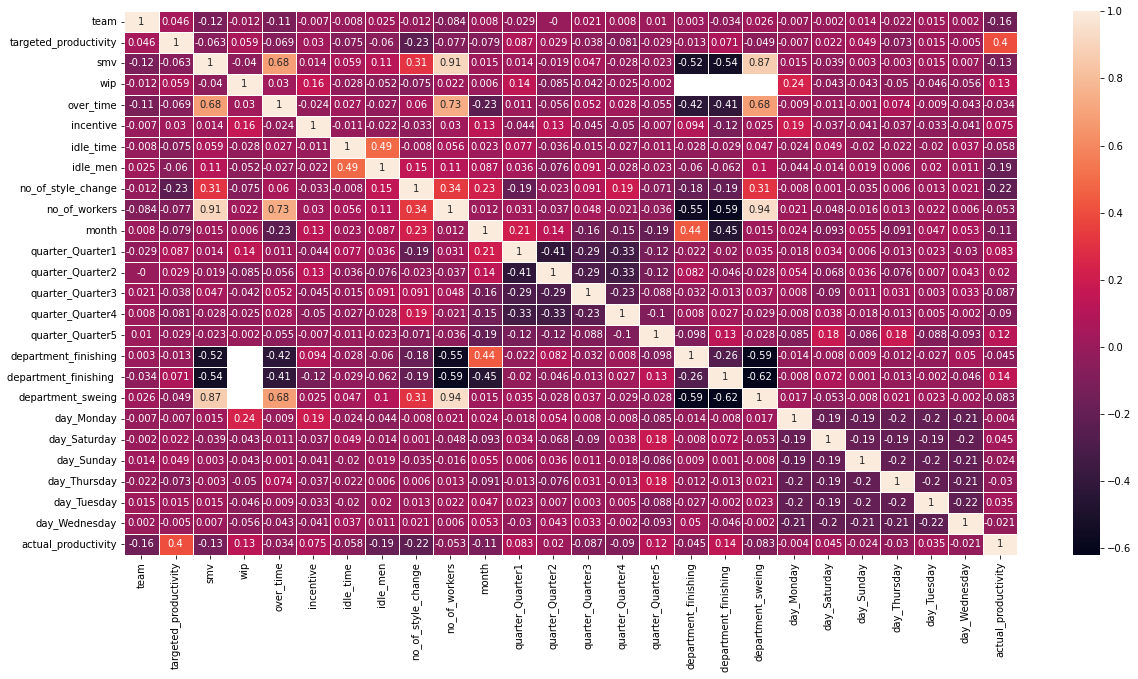

In [18]:
corr = employee.corr(method = 'pearson').round(3)
plt.figure(figsize = (20,10))
sns.heatmap(data = corr, annot = True, linewidth = .5) 

## Entraînement
### Préparation
#### Variable d'intérêt

In [19]:
employee = employee.dropna(subset=['team', 'targeted_productivity', 'smv', 'wip', 'idle_men', 'month', 'quarter_Quarter5', 'department_finishing', 'actual_productivity'])
employee = employee.reset_index()
employee['team'] = pd.factorize(employee['team'])[0]
employee['department_finishing'] = pd.factorize(employee['department_finishing'])[0]
X = pd.DataFrame(np.c_[employee['team'], employee['targeted_productivity'], employee['smv'], employee['wip'], employee['idle_men'], employee['month'], employee['quarter_Quarter5'], employee['department_finishing']], 
                 columns = ['team', 'targeted_productivity', 'smv', 'wip', 'idle_men', 'month', 'quarter_Quarter5', 'department_finishing'])
y = employee['actual_productivity']

### Division du jeu de données
#### Effectifs

In [20]:
n_train = round(len(employee) * 0.6)
n_test = round(len(employee) * 0.2)
n_calib = len(employee) - (n_train + n_test)
print(n_train, n_test, n_calib)

356 119 119


#### Division

In [21]:
X_train = X[0:n_train]
y_train = y[0:n_train]
X_calib = X[n_train:(n_train + n_test)]
y_calib = y[n_train:(n_train + n_test)]
X_test = X[(n_train + n_test):]
y_test = y[(n_train + n_test):]

### Modèle
#### Création du modèle

In [22]:
#nc = NcFactory.create_nc(KNeighborsRegressor(n_neighbors=11)) # accuracy 0.96
#nc = NcFactory.create_nc(RandomForestRegressor(n_estimators=500)) # accuracy 0.96
nc = NcFactory.create_nc(DecisionTreeRegressor(min_samples_leaf=5)) # accuracy 0.97
icp = IcpRegressor(nc)

#### Entraînement

In [23]:
icp.fit(X_train, y_train)

#### Calibration

In [24]:
icp.calibrate(X_calib, y_calib)

## Prédiction
### Prédiction des valeurs
95% de confiance

In [ ]:
y_pred = icp.predict(X_test.values, significance = 0.05)

In [26]:
print("Intervalles de prédiction à 95% de confiance :\n", y_pred[:5, :])
print("\nValeurs réelles :\n", y_test[:5])

Intervalles de prédiction à 95% de confiance :
 [[0.3278973  0.8893394 ]
 [0.40896035 0.97040245]
 [0.46987095 1.03131305]
 [0.43686788 0.99830998]
 [0.44005261 1.00149471]]

Valeurs réelles :
 475    0.650307
476    0.602000
477    0.750283
478    0.700605
479    0.800137
Name: actual_productivity, dtype: float64


In [27]:
y_pred[0, 0]

0.32789729583333327

In [28]:
y_test

475    0.650307
476    0.602000
477    0.750283
478    0.700605
479    0.800137
         ...   
589    0.800021
590    0.497885
591    0.750593
592    0.800137
593    0.900130
Name: actual_productivity, Length: 119, dtype: float64

#### Niveau de précision

In [29]:
suc = 0
for i in range(n_test):
    if (y_test[(n_train + n_test + i)] > y_pred[i,0]) and (y_test[(n_train + n_test + i)] < y_pred[i,1]):
      suc += 1
acc = suc / n_test
("Précision du modèle :", acc)

('Précision du modèle :', 0.9663865546218487)